# Demo of graph optimisation to segment dummy structures

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import h5py
import mrcfile
from skimage.util import montage


In [2]:
from grace.base import GraphAttrs
from grace.models.optimise import optimise_graph
from grace.simulate import random_graph, random_graph_mixed_motifs


### Synthesize a fake image:

In [28]:
def create_blank_image(image_value: float, image_shape: tuple[int, int]):
    image = np.zeros(shape=image_shape, dtype=np.float32)
    image += image_value
    return image


In [29]:
value = 127
scale = 3500

image = create_blank_image(image_value=value, image_shape=(scale, scale))
image.shape, image

((3500, 3500),
 array([[127., 127., 127., ..., 127., 127., 127.],
        [127., 127., 127., ..., 127., 127., 127.],
        [127., 127., 127., ..., 127., 127., 127.],
        ...,
        [127., 127., 127., ..., 127., 127., 127.],
        [127., 127., 127., ..., 127., 127., 127.],
        [127., 127., 127., ..., 127., 127., 127.]], dtype=float32))

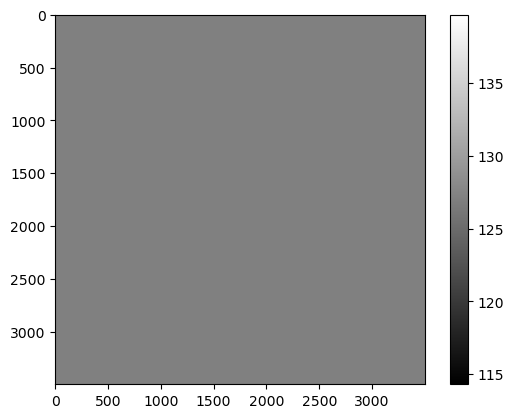

In [30]:
plt.imshow(image, cmap='binary_r')
plt.colorbar()
plt.show()

### Load a dummy graph:

In [31]:
G = random_graph(n_motifs=5, n_chaff=100, scale=scale, density=0.025, motif="line")

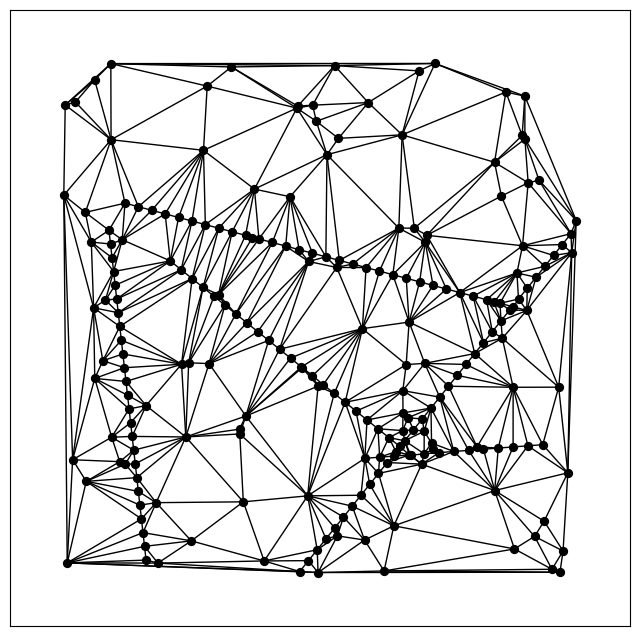

In [32]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in G.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(G, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

### Update the graph with bimodal node & edge predictions:

In [33]:
# NOTE(arl): this is *super* hacky - just to see if the optimisation works

def update_graph_dummy(G: nx.Graph):

    nodes = list(G.nodes.data())

    for _, node in nodes:
        pd = np.random.random()*0.5
        if node["label"] > 0:
            node[GraphAttrs.NODE_PREDICTION] = pd
        else:
            node[GraphAttrs.NODE_PREDICTION] = 1-pd

    
    for edge in G.edges.data():
        pd = np.random.random()*0.1
        _, e_i = nodes[edge[0]]
        _, e_j = nodes[edge[1]]
        
        if e_i["object_idx"] == e_j["object_idx"] and e_i["label"] > 0:
            edge[2][GraphAttrs.EDGE_PREDICTION] = 1 - pd
        else:
            edge[2][GraphAttrs.EDGE_PREDICTION] = pd 


In [34]:
update_graph_dummy(G)


### Project the nodes into the image:

In [35]:
coords = np.array([pos[item] for item in pos.keys()])
coords.shape, coords[0].min(), coords[0].max(), coords[1].min(), coords[1].max()

((225, 2),
 1021.3851674712176,
 2835.8740730136506,
 56.69061400260722,
 3320.54672080804)

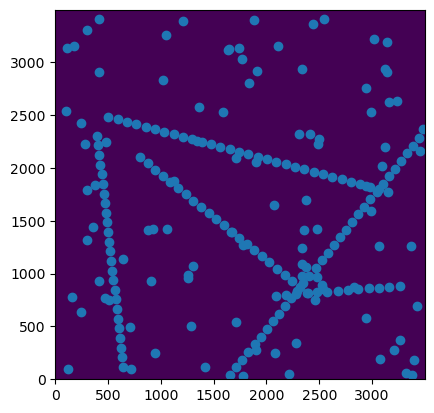

In [36]:
plt.imshow(image, origin="lower")
plt.scatter(x=coords[:, 0], y=coords[:, 1])


In [37]:
# Separate the real nodes from the fake nodes:

real_nodes, fake_nodes = [], []

for idx, node in G.nodes.data():
    if node['label'] > 0:
        real_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])
    else:
        fake_nodes.append([node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]])

real_coords = np.array(real_nodes)
fake_coords = np.array(fake_nodes)
real_coords.shape, fake_coords.shape

((125, 2), (100, 2))

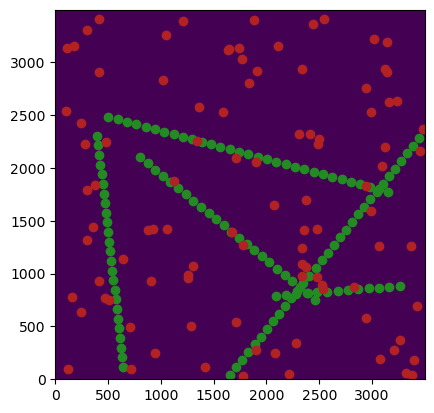

In [38]:
plt.imshow(image, origin="lower")
plt.scatter(x=real_coords[:, 0], y=real_coords[:, 1], color='forestgreen')
plt.scatter(x=fake_coords[:, 0], y=fake_coords[:, 1], color='firebrick')


##### Visualise how the edge weights are distributed:


In [39]:
def plot_node_and_edge_label_distribution(graph: nx.Graph) -> None: 

    node_true = [node['label'] for _, node in graph.nodes(data=True)]
    # node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True)]

    real_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] > 0]
    fake_node_pred = [node['node_prediction'] for _, node in graph.nodes(data=True) if node['label'] <= 0]

    plt.hist(real_node_pred, color="forestgreen", label=f"Real nodes ({len(real_node_pred)})")
    plt.hist(fake_node_pred, color="firebrick", label=f"Fake nodes ({len(fake_node_pred)})")
    plt.title(f"Distribution of synthetic prediction values in {len(real_node_pred) + len(fake_node_pred)} nodes")
    plt.legend()
    plt.show()



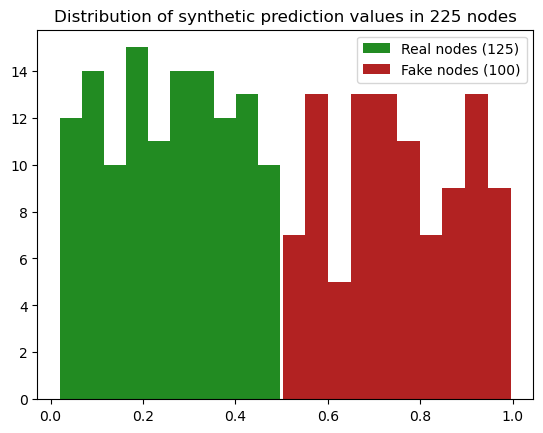

In [40]:
plot_node_and_edge_label_distribution(graph=G)

### Now read the coords of real & fake nodes & color-code the image accordingly:

In [41]:
real_coords.shape

(125, 2)

In [42]:
def synthesize_image_from_graph(G: nx.Graph, image_value: float, image_shape: tuple[int, int], patch_shape: tuple[int, int]):
    """ Synthesizes a 2D fake image of specified shape with 
        white patch centres of real nodes (belonging to an object) 
        and black patch centres of fake nodes (random noisy nodes).
    """

    # Create a fake image:
    img = create_blank_image(image_value=image_value, image_shape=image_shape)
    img = np.pad(img, pad_width=patch_shape, mode='constant', constant_values=value)
    # print (image.shape, img.shape)

    patch_black = np.zeros(shape=patch_shape, dtype=image.dtype)
    patch_white = np.ones(shape=patch_shape, dtype=image.dtype) * 255
    
    for _, node in G.nodes.data():
        coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
        st_x, en_x = int(coords[0]) + patch_shape[0] - patch_shape[0] // 2, int(coords[0]) + patch_shape[0] + patch_shape[0] // 2
        st_y, en_y = int(coords[1]) + patch_shape[1] - patch_shape[1] // 2, int(coords[1]) + patch_shape[1] + patch_shape[1] // 2

        # print (coords, node['label'], "points", st_x, en_x, st_y, en_y)

        if node['label'] > 0:  # real node with GT = 1
            img[st_x:en_x, st_y:en_y] = patch_white
        else:
            img[st_x:en_x, st_y:en_y] = patch_black

    img = img[patch_shape[0]:-patch_shape[0], patch_shape[1]:-patch_shape[1]]
    return img

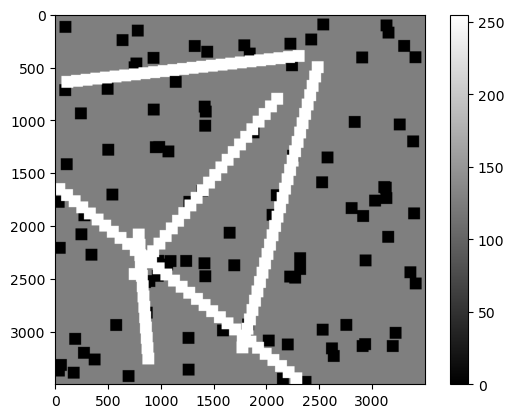

In [43]:
patch_shape = (112, 112)
image = synthesize_image_from_graph(G, image_value=value, image_shape=(scale, scale), patch_shape=patch_shape)
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.show()

### Visualise a few training patch montages:

In [44]:
def montage_from_image(G: nx.Graph, image: np.ndarray, crop_shape: tuple[int, int]):

    crops = [[], []]
    img = np.pad(image, pad_width=crop_shape, mode='constant')
    
    for _, node in G.nodes.data():
        coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]
        st_x, en_x = int(coords[0]) + crop_shape[0] - crop_shape[0] // 2, int(coords[0]) + crop_shape[0] + crop_shape[0] // 2
        st_y, en_y = int(coords[1]) + crop_shape[1] - crop_shape[1] // 2, int(coords[1]) + crop_shape[1] + crop_shape[1] // 2

        # print (coords, node['label'], "points", st_x, en_x, st_y, en_y)
        crop = img[st_x:en_x, st_y:en_y]
        crops[node['label']].append(crop)

    for c, crop_collection in enumerate(crops):
        mont = montage(crop_collection[:49], grid_shape=(7, 7))
        plt.imshow(mont)
        plt.title(f"Montage of patches with 'node_label' = {c}")
        plt.show()
        

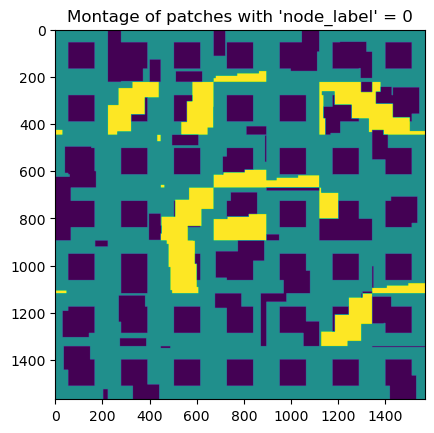

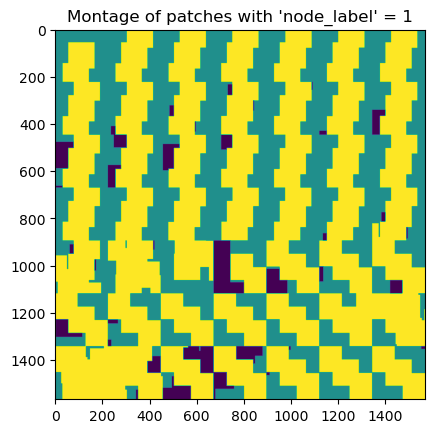

In [45]:
montage_from_image(G, image, crop_shape=[item*2 for item in patch_shape])

### Save the image as `mrc` file and the positions of the nodes as `h5` file:

In [46]:
def save_image_and_nodes_combo(image: np.ndarray, nodes: np.ndarray, image_number: int):

    save_dr = "/Users/kulicna/Desktop/classifier/data_fake/"
    save_fn = f"MRC_File_{str(image_number).zfill(3)}.mrc"
    save_h5 = save_fn.replace("mrc", "h5")

    SAVE_IMAGE = os.path.join(save_dr, save_fn)
    SAVE_NODES = os.path.join(save_dr, save_h5)

    with mrcfile.new(SAVE_IMAGE, overwrite=True) as mrc:
        mrc.set_data(image)

    coords_df = pd.DataFrame(nodes, columns=["x", "y"])
    coords_df.to_hdf(SAVE_NODES, key='df', mode='w')


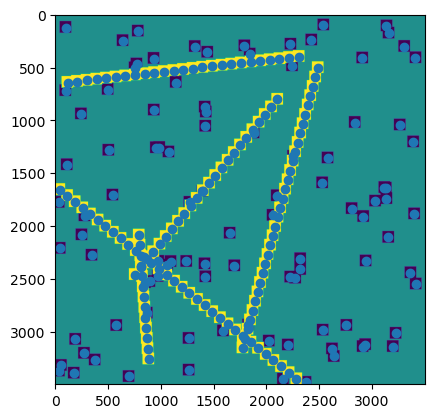

In [47]:
# Plot the image & nodes together correspondingly:

plt.imshow(image)
plt.scatter(coords[:, 1], coords[:, 0])
plt.show()

In [48]:
save_image_and_nodes_combo(image=image.T, nodes=coords, image_number=3)

In [25]:
# coords.shape

(207, 2)

In [26]:
# df = pd.DataFrame(coords, columns=['x', 'y'])
# df

,x,y
0,1883.505259,1105.345332
1,3198.741744,1490.601012
2,2416.666908,1947.023493
3,1470.635046,2082.368066
4,3290.170000,2266.823816
...,...,...
202,1831.188368,2160.908509
203,1771.670302,2232.729376
204,1712.152236,2304.550243
205,1652.634170,2376.371110


In [79]:
coords

array([[2.00154214e+03, 1.14235844e+01, 2.71572171e+02, 2.48212746e+03,
        6.56028380e+02, 3.43391531e+03, 1.51120902e+03, 5.83703678e+02,
        2.28940734e+03, 8.74262832e+02, 1.43413728e+02, 2.50020308e+03,
        2.94450791e+03, 1.86612599e+03, 2.55159801e+03, 1.02104304e+03,
        1.09862892e+03, 9.51403637e+02, 7.68938336e+02, 2.09023514e+03,
        3.39444429e+03, 4.59270903e+02, 1.51722186e+03, 2.44302638e+03,
        9.90030884e+02, 2.08845964e+03, 2.17860746e+03, 1.61061821e+03,
        1.09556756e+03, 3.37380691e+03, 3.43109125e+03, 6.13429609e+02,
        8.97388563e+02, 2.44637037e+03, 2.99402239e+03, 8.06145842e+02,
        1.45465047e+03, 9.51396196e+02, 3.11629704e+03, 1.08928114e+02,
        8.56966366e+01, 1.77866842e+03, 2.35397465e+03, 9.30835435e+01,
        2.23407392e+02, 1.07222452e+03, 1.42234191e+03, 8.03396187e+02,
        2.81771524e+03, 2.89643148e+03, 2.84588537e+01, 8.54737688e+01,
        2.02869882e+03, 4.45453760e+02, 1.94849072e+03, 2.431131

In [ ]:
def 

In [95]:
nodes = coords.T
nodes.shape

(175, 2)

In [96]:
nodes[:10]

array([[2001.54213791,  425.44522129],
       [  11.42358436, 1788.08694268],
       [ 271.57217082, 1075.23670461],
       [2482.12746225, 1224.13321677],
       [ 656.02838036, 1744.72680515],
       [3433.91530967,  340.40837364],
       [1511.20902064, 1784.58117819],
       [ 583.70367834, 2824.03263155],
       [2289.40734017, 3183.59910823],
       [ 874.26283196,  785.17134471]])

In [99]:
flipped = np.flip(nodes, axis=1)
flipped.shape

(175, 2)

In [100]:
flipped[:10]

array([[ 425.44522129, 2001.54213791],
       [1788.08694268,   11.42358436],
       [1075.23670461,  271.57217082],
       [1224.13321677, 2482.12746225],
       [1744.72680515,  656.02838036],
       [ 340.40837364, 3433.91530967],
       [1784.58117819, 1511.20902064],
       [2824.03263155,  583.70367834],
       [3183.59910823, 2289.40734017],
       [ 785.17134471,  874.26283196]])

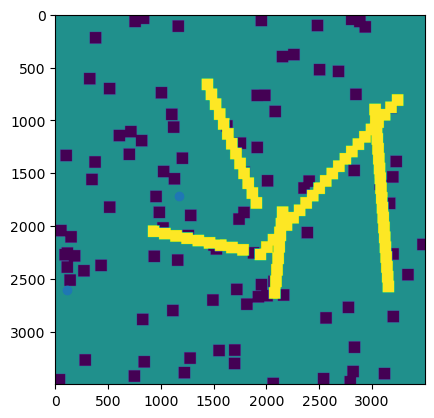

In [24]:
plt.imshow(image)
plt.scatter(coords[1], coords[0])

### Visualise the optimised graph & individual objects:

In [66]:
x = optimise_graph(G)

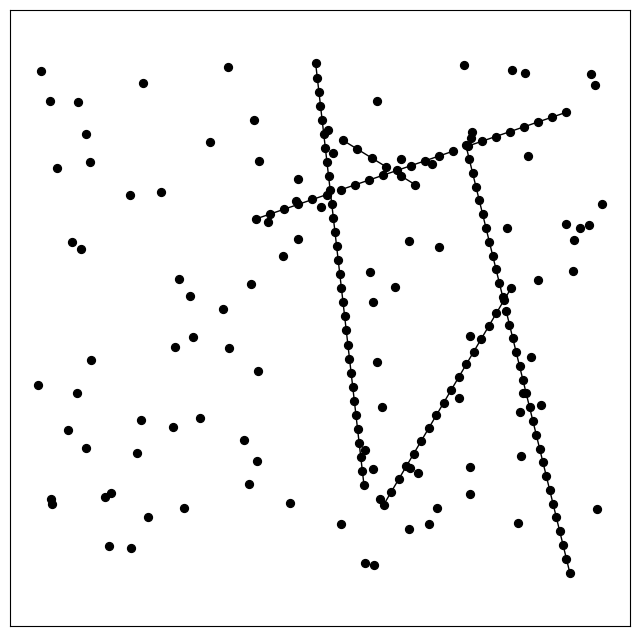

In [67]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()

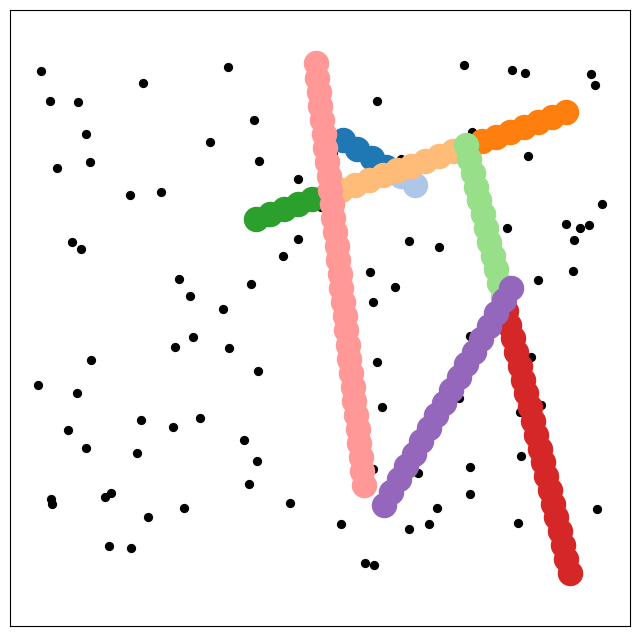

In [68]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Repeat on a few graphs at a time:

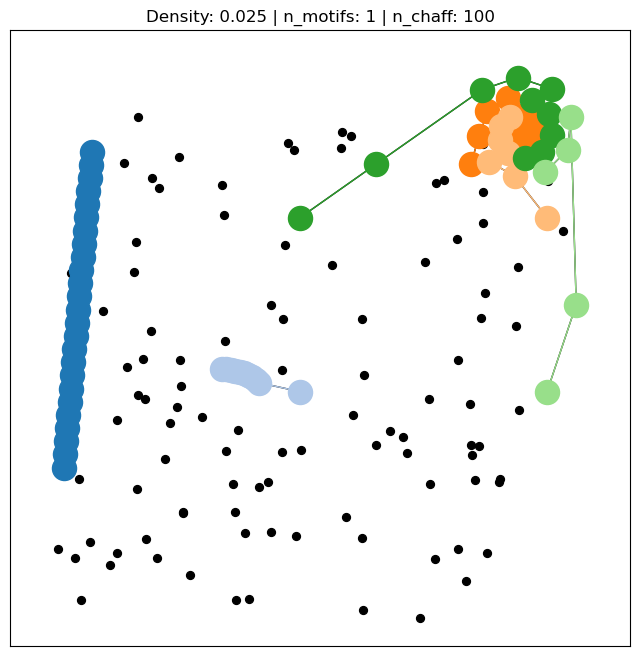

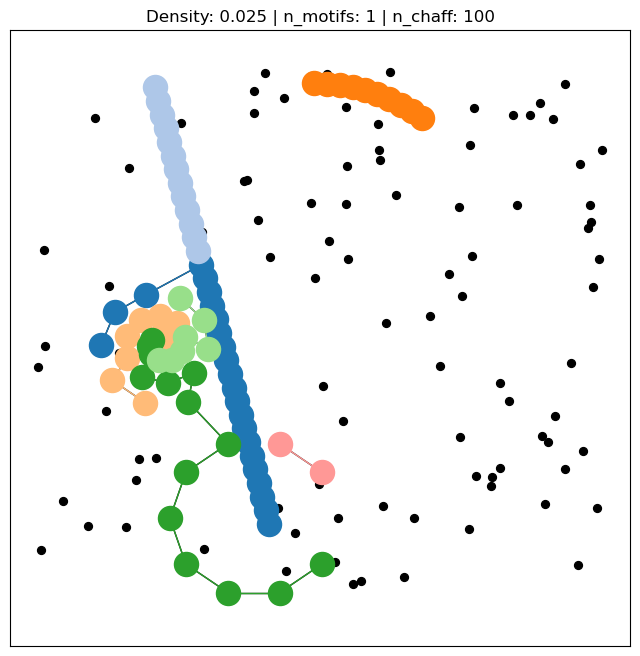

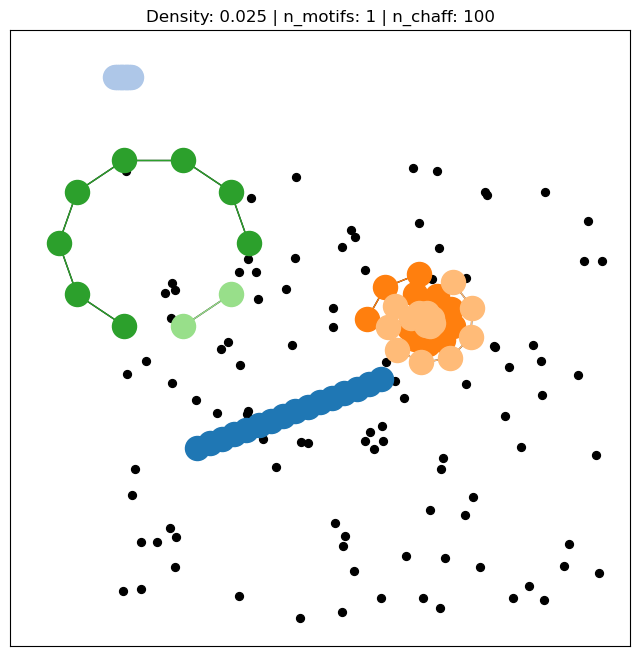

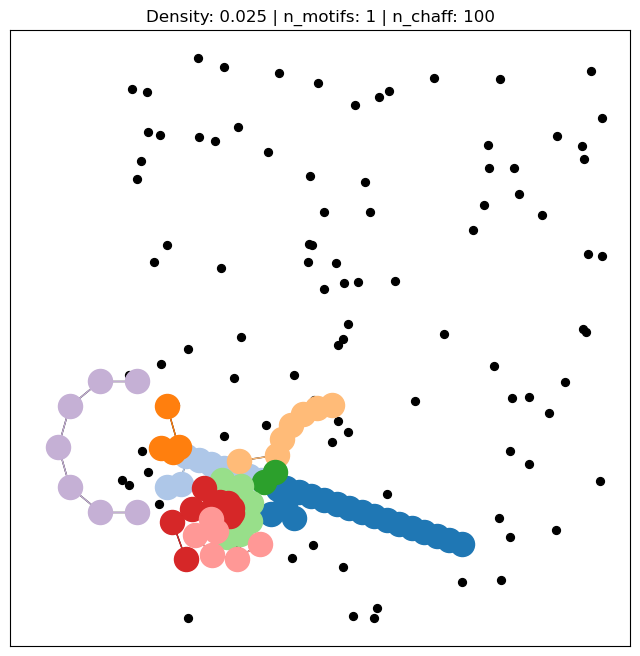

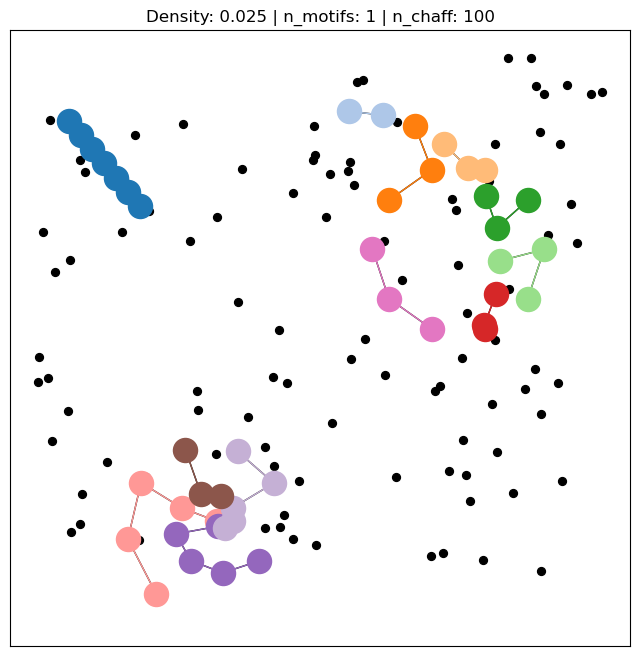

In [69]:
num_trials = 5
density = 0.025
n_motifs = 1
n_chaff = 100

for i in range(num_trials):
    # G = random_graph(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    G = random_graph_mixed_motifs(n_motifs=n_motifs, n_chaff=n_chaff, scale=1.0, density=density)
    update_graph_dummy(G)
    x = optimise_graph(G)
    
    # Plot:
    pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
    fig, ax = plt.subplots(figsize=(8, 8))

    # draw all nodes/vertices in the graph, including those not determined to be 
    # part of the objects
    nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

    # get each connected subgraph and draw it with a different colour
    cc = nx.connected_components(x)
    for index, sg in enumerate(cc):
        
        if len(sg) <= 1:
            continue

        c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
        sg = x.subgraph(sg).copy()
        plt.title(f"Density: {density} | n_motifs: {n_motifs} | n_chaff: {n_chaff}")
        nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

    plt.show()